# Health Insurance Cost Prediction with Linear Regression

This project uses linear regression models to predict medical insurance charges based on personal and lifestyle attributes such as age, sex, BMI, number of children, and smoking status. The dataset is commonly used for regression tasks and highlights the importance of feature relationships, encoding, scaling, and model selection in a real-world predictive scenario.


#Descriptive Statistics and Missing Values

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import random
import os

# Load dataset
insurance_df = pd.read_csv("insurance.csv")
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Observation:**

The dataset has been loaded and previewed. It contains information about individuals, including medical charges and factors like BMI, smoking status, and region.


In [77]:
# Separate numeric and categorical variables
numeric_df = insurance_df.select_dtypes(include=np.number)
categorical_df = insurance_df.select_dtypes(include=object)


In [78]:
# Summary statistics for numeric features
numeric_df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [79]:
# Summary statistics for categorical features
categorical_df.describe()


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [80]:
# Check for missing values
missing_values = insurance_df.isna().sum() / len(insurance_df)
print("There are no missing values in the dataset.")
missing_values


There are no missing values in the dataset.


,0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


**Observation:**

The dataset is clean and complete. No missing values were detected.


#Distribution and Outlier Visualization

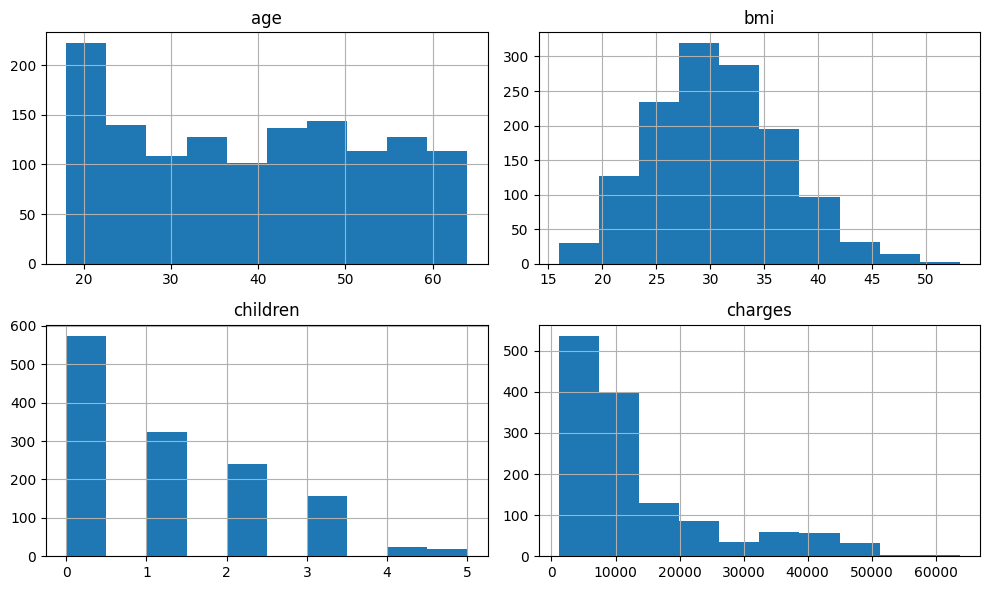

In [81]:
# Histograms for numeric variables
numeric_df.hist(figsize=(10, 6))
plt.tight_layout()
plt.show()


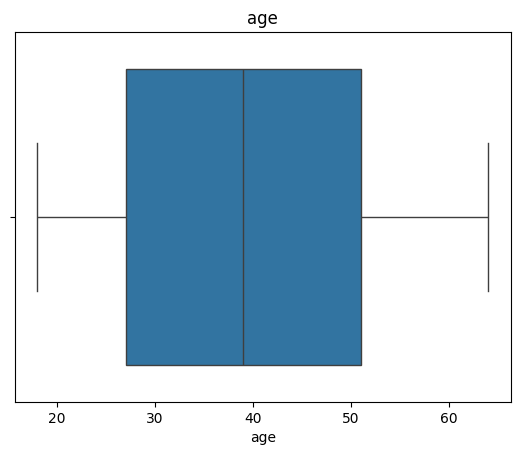

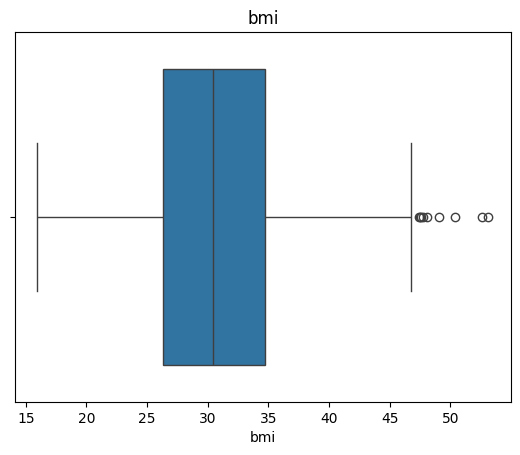

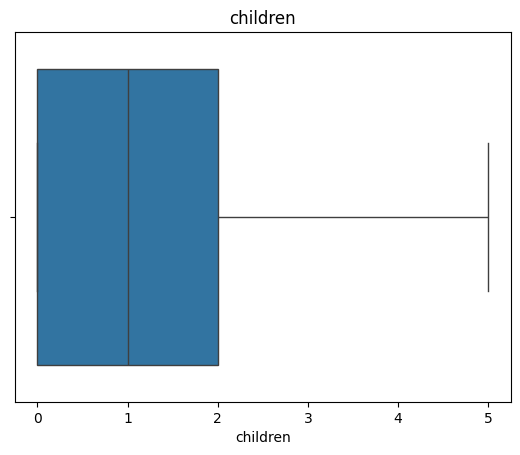

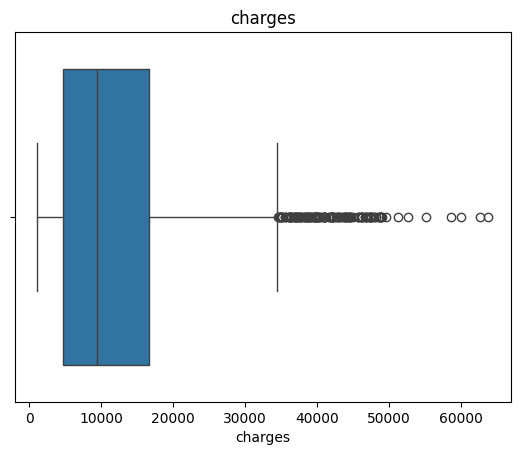

In [82]:
# Boxplots to visualize outliers in numeric variables
for col in numeric_df.columns:
    plt.figure()
    sns.boxplot(x=numeric_df[col])
    plt.title(col)
    plt.show()


**Observation:**

Several numeric variables show skewness and outliers, particularly in `charges` and `bmi`.


#Categorical Variables Distribution

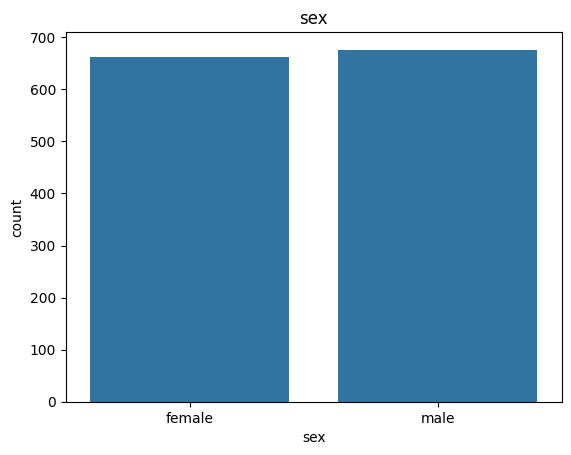

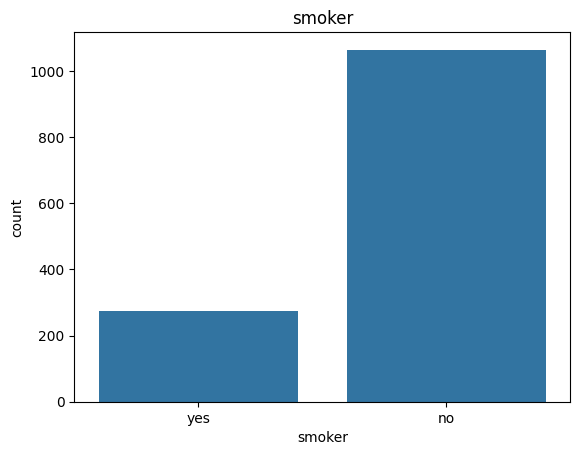

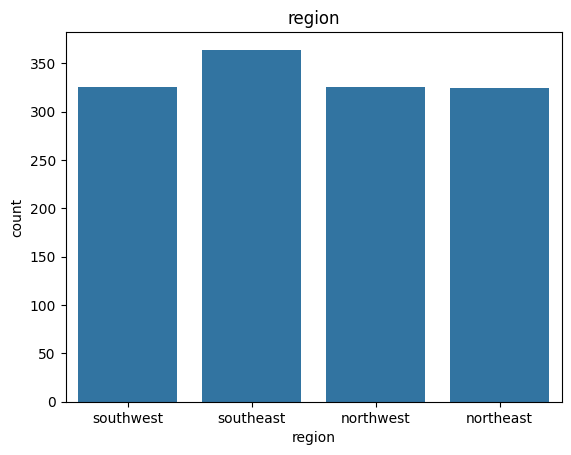

In [83]:
# Count plots for categorical features
for col in categorical_df.columns:
    plt.figure()
    sns.countplot(data=categorical_df, x=col)
    plt.title(col)
    plt.show()


#Exploring Relationships with Charges


<Axes: xlabel='sex', ylabel='charges'>

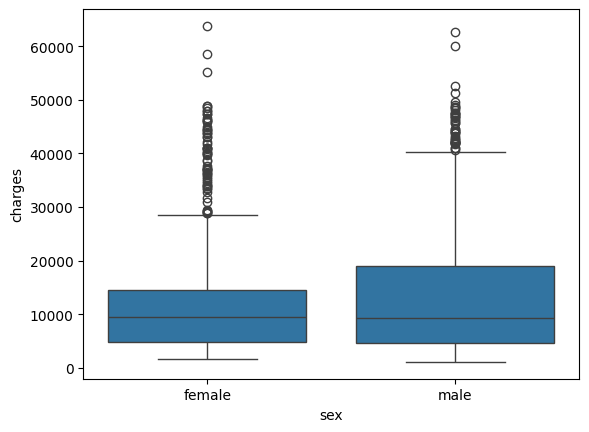

In [84]:
# Relationship between sex and charges
sns.boxplot(data=insurance_df, x="sex", y="charges")


**Observation:**

The average insurance charge is similar across genders. Both distributions are right-skewed, slightly more for males.


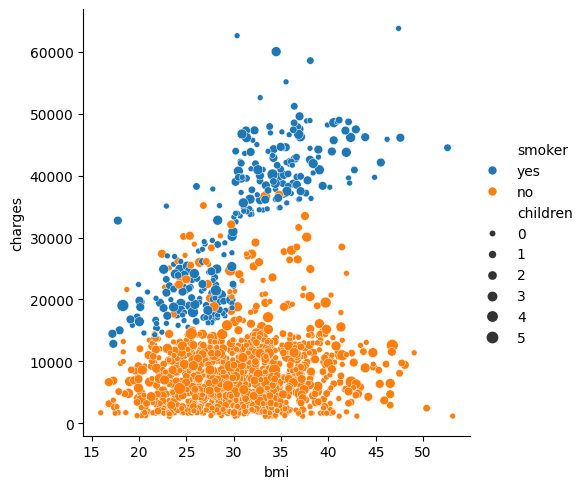

In [85]:
# Scatterplot for BMI vs Charges, highlighting smoker status and number of children
sns.relplot(data=insurance_df, x="bmi", y="charges", hue="smoker", size="children", kind="scatter")


**Observation:**

- Smokers tend to have higher charges.
- Among smokers, there is a positive correlation between BMI and insurance charges.
- No clear correlation is observed between number of children and charges.


#Outlier Detection and Profiling in Charges

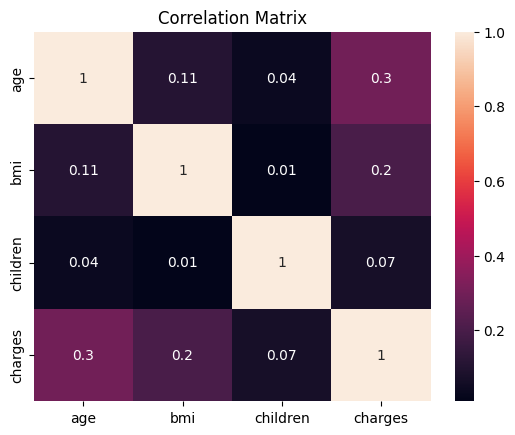

In [86]:
# Correlation heatmap to examine linear relationships
sns.heatmap(numeric_df.corr().round(2), annot=True)
plt.title("Correlation Matrix")
plt.show()


**Observation:**

`charges` is moderately correlated with `age`, `bmi`, and `children`. Further analysis will focus on those variables.


In [87]:
#* Detect outliers in 'charges' using IQR method
q1 = insurance_df["charges"].quantile(0.25)
q3 = insurance_df["charges"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_df = insurance_df[(insurance_df["charges"] < lower_bound) | (insurance_df["charges"] > upper_bound)]

#* Examine average BMI and age of outliers
outliers_df[["bmi", "age"]].mean()


,0
bmi,35.564604
age,41.079137


In [88]:
# Display all outlier records
outliers_df


,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


**Observation:**

The outliers in `charges` tend to have higher BMI and age, confirming that high-risk individuals pay much higher premiums.


In [89]:
# Gender proportion among outliers (relative to dataset)
gender_ratio = outliers_df["sex"].value_counts() / insurance_df["sex"].value_counts() * 100
gender_ratio


,count
sex,
male,13.16568
female,7.55287


In [90]:
# Smoker proportion among outliers (relative to dataset)
smoker_ratio = outliers_df["smoker"].value_counts() / insurance_df["smoker"].value_counts() * 100
smoker_ratio


,count
smoker,
no,0.281955
yes,49.635036


**Observation**

- A significantly higher proportion of smokers fall into the outlier group.
- Gender distribution is relatively similar to the original dataset.


# Train/Test Split and Preprocessing

In [91]:
# Reset index to ensure consistency
insurance_df.reset_index(drop=True, inplace=True)

# Separate features and target variable
y = insurance_df['charges']
x = insurance_df.drop(['charges'], axis=1)
x


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [92]:
# split with sklearn's stratified split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=x["smoker"], test_size=0.2, random_state=1
)

x_train


,age,sex,bmi,children,smoker,region
42,41,male,21.780,1,no,southeast
847,23,male,50.380,1,no,southeast
625,29,female,26.030,0,no,northwest
394,46,female,32.300,2,no,northeast
621,37,male,34.100,4,yes,southwest
...,...,...,...,...,...,...
56,58,female,31.825,2,no,northeast
599,52,female,37.525,2,no,northwest
36,62,female,32.965,3,no,northwest
1179,31,male,29.810,0,yes,southeast


In [93]:
# Create preprocessing pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
minmax_scaler = MinMaxScaler()

preprocessing = make_column_transformer(
    (minmax_scaler, make_column_selector(dtype_include=np.number)),
    (one_hot_encoder, make_column_selector(dtype_include=object)),
)

# Apply transformations to training set
x_train_processed = pd.DataFrame(
    preprocessing.fit_transform(x_train),
    columns=preprocessing.get_feature_names_out()
)

x_train_processed



,minmaxscaler__age,minmaxscaler__bmi,minmaxscaler__children,onehotencoder__sex_male,onehotencoder__smoker_yes,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest
0,0.500000,0.136720,0.2,1.0,0.0,0.0,1.0,0.0
1,0.108696,0.924274,0.2,1.0,0.0,0.0,1.0,0.0
2,0.239130,0.253752,0.0,0.0,0.0,1.0,0.0,0.0
3,0.608696,0.426408,0.4,0.0,0.0,0.0,0.0,0.0
4,0.413043,0.475974,0.8,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1065,0.869565,0.413328,0.4,0.0,0.0,0.0,0.0,0.0
1066,0.739130,0.570288,0.4,0.0,0.0,1.0,0.0,0.0
1067,0.956522,0.444720,0.6,0.0,0.0,1.0,0.0,0.0
1068,0.282609,0.357841,0.0,1.0,1.0,0.0,1.0,0.0


**Observation:**  
A column transformer is used to scale numerical features and one-hot encode categorical ones. Dropping the first category prevents multicollinearity.


# Model Training and Evaluation

In [94]:
# Train a basic linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

linear_regressor = LinearRegression()

lin_reg = make_pipeline(preprocessing, linear_regressor)
lr_model = lin_reg.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
r2_score(y_test, y_pred)


0.7538547215244324

**Observation:**

A baseline linear regression model is trained and evaluated using R². This serves as a reference for comparison with further improvements.


In [95]:
# Apply IQR capping to target variable to reduce outlier impact
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr

y_train = y_train.apply(lambda val: upper_limit if val > upper_limit else val)
y_test = y_test.apply(lambda val: upper_limit if val > upper_limit else val)

print("Upper limit:", upper_limit)
print("y_train max:", y_train.max())
print("y_test max:", y_test.max())


Upper limit: 35861.965118750006
y_train max: 35861.965118750006
y_test max: 35861.965118750006


**Observation:**

Outliers in the target variable charges are capped to prevent them from distorting the linear regression model.

In [96]:
# Retrain model after capping
lr_model2 = lin_reg.fit(x_train, y_train)
y_pred = lr_model2.predict(x_test)
r2_score(y_test, y_pred)


0.7605675404609118

**Observation:**

R² is re-evaluated after target variable capping. If performance improves, the transformation was helpful.

In [97]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

scaler = StandardScaler()
encoder = OrdinalEncoder()

preprocessing = make_column_transformer(
    (scaler, make_column_selector(dtype_include=np.number)),
    (encoder, make_column_selector(dtype_include=object)),
)

lin_reg = make_pipeline(preprocessing, linear_regressor)
lr_model3 = lin_reg.fit(x_train, y_train)
y_pred = lr_model3.predict(x_test)
r2_score(y_test, y_pred)


0.760641184429659

**Observation:**

Ordinal encoding and standardization are used instead of one-hot encoding + MinMax. This reduces dimensionality and may improve generalization.


#Polynomial Feature Expansion

In [98]:
from sklearn.preprocessing import PolynomialFeatures

# Compare polynomial degrees from 1 to 5
for degree in range(1, 6):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = make_pipeline(preprocessing, poly, LinearRegression())
    model = lin_reg.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"Degree {degree} R² score: {r2_score(y_test, y_pred):.4f}")

# Train best model (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
lin_reg = make_pipeline(preprocessing, poly, LinearRegression())
lr_model4 = lin_reg.fit(x_train, y_train)
y_pred = lr_model4.predict(x_test)

print("\nBest model uses polynomial degree 2.")


Degree 1 R² score: 0.7606
Degree 2 R² score: 0.8155
Degree 3 R² score: 0.8085
Degree 4 R² score: 0.7689
Degree 5 R² score: 0.3784

Best model uses polynomial degree 2.


**Observation:**

Polynomial features improve the model's flexibility. Degree 2 offers the best tradeoff between complexity and performance.

## Conclusion

Regression models can effectively estimate medical insurance costs using personal and lifestyle variables. In this case, smoker status and BMI were the most influential predictors of higher charges.

Key takeaways:
- Data scaling and encoding significantly affect model performance.
- A polynomial regression of degree 2 improved the R² score compared to a linear model.
- Proper handling of outliers and skewed distributions improved prediction consistency.

This project corresponds to the **Modeling** stage of the CRISP-DM methodology.
